### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.rename(columns={'v1':'Labels', 'v2':'Message'}, inplace=True)

In [7]:
df['Labels'].value_counts()

ham     4825
spam     747
Name: Labels, dtype: int64

In [8]:
df['Labels'] = df['Labels'].map({'ham':0, 'spam':1})

#### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['Message']
y = df['Labels']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### Spam Word Cloud

In [12]:
spam_words = ' '.join(list(df[df['Labels']==1]['Message']))

In [13]:
spam_wc = WordCloud(width=500, height=500).generate(spam_words)

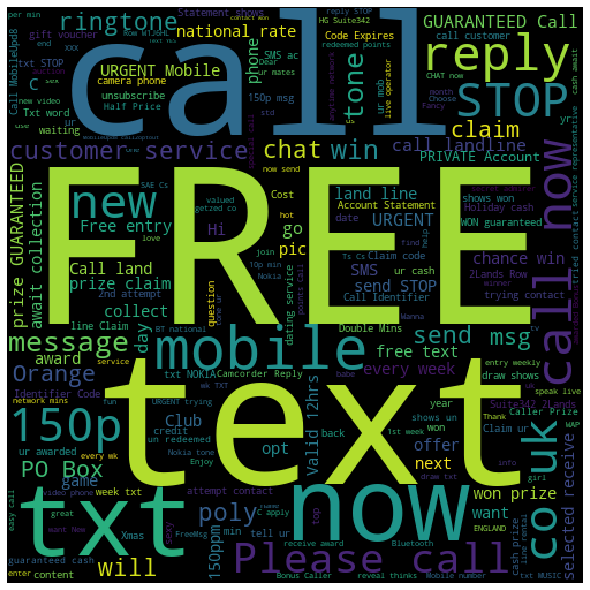

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Ham Word Cloud

In [15]:
ham_words = ' '.join(df[df['Labels']==0]['Message'])

In [16]:
ham_wc = WordCloud(width=500, height=500, background_color='black').generate(ham_words)

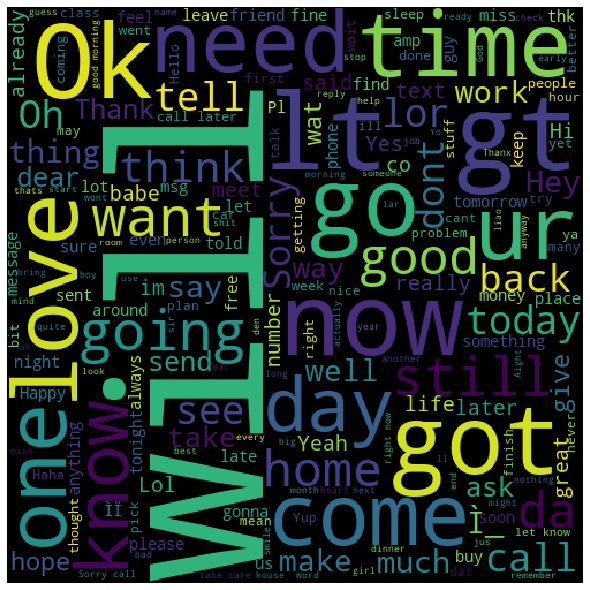

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Feature Engineering

In [18]:
df['Length'] = df['Message'].apply(len)

In [19]:
df.head()

,Labels,Message,Length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [20]:
sns.set_style('whitegrid')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023194BDEA90>,
      dtype=object)

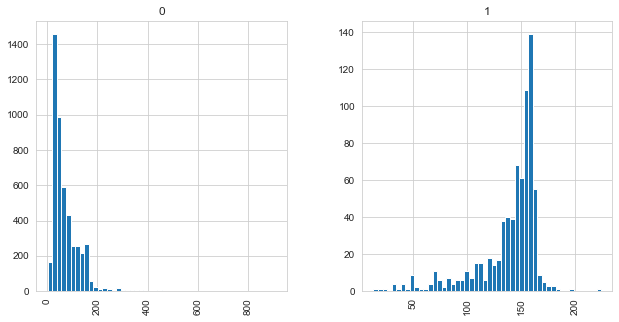

In [21]:
df.hist(column='Length', by='Labels', bins=50, figsize=(10,5))

In [22]:
df[df['Labels']==0]['Length'].mean()

71.02362694300518

In [23]:
df[df['Labels']==1]['Length'].mean()

138.8661311914324

Usually the spam message length is longer

### Text Processing (Tokenization, Removing Stopwords, Normalization)

In [25]:
import string

In [33]:
def text_process(message):
    """
    1. Remove Punctuation (Normalization)
    2. Remove StopWords
    3. Return list of clean text words (Tokenization)
    """
    temp = [c for c in message if c not in string.punctuation]
    temp = ''.join(temp)
    return [word.lower() for word in temp.split() if word.lower() not in stopwords.words('english')]

### Transforming into Bag of Words Model

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
bow_model = CountVectorizer(analyzer=text_process, ngram_range=(1,2)).fit(df['Message'])

In [37]:
len(bow_model.vocabulary_)

9431

In [42]:
messages_bow = bow_model.transform(df['Message'])

In [44]:
messages_bow.nnz # Amount of Non Zero occurances

49772

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

In [52]:
tfidf_model = TfidfTransformer().fit(messages_bow)

In [59]:
messages_tfidf = tfidf_model.transform(messages_bow)

In [62]:
messages_tfidf.shape

(5572, 9431)

### Applying Multinomial Naive Bayes Classifier

In [54]:
from sklearn.naive_bayes import MultinomialNB

In [55]:
spam_ham_model = MultinomialNB().fit(messages_tfidf, df['Labels'])

### Creating Pipeline for all the steps

In [67]:
from sklearn.pipeline import Pipeline

#### MultinomialNB Classifier

In [89]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process, ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [90]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000231971D4488>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [91]:
predictions = pipeline.predict(X_test)

#### Checking the Accuracy of the Model

In [92]:
from sklearn.metrics import classification_report, confusion_matrix

In [93]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1217
           1       1.00      0.71      0.83       176

    accuracy                           0.96      1393
   macro avg       0.98      0.86      0.91      1393
weighted avg       0.96      0.96      0.96      1393



In [94]:
print(confusion_matrix(y_test, predictions))

[[1217    0]
 [  51  125]]


#### SVM Model

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [108]:
pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer=text_process) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SVC' , SVC(gamma='auto', C=1000)),
                    ])


parameters_SVC = dict(tfidf=[None, TfidfTransformer()],
                      clf_SVC__C=[500, 1000,1500]
                      )
#parameters = {'tfidf__use_idf': (True, False),    }

grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=-1, verbose=1)

grid_SVC.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function text_process at 0x00000231971D4488>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
      

In [110]:
grid_SVC.best_params_

{'clf_SVC__C': 500, 'tfidf': None}

In [115]:
pred = grid_SVC.predict(X_test)

In [116]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1217
           1       0.99      0.86      0.92       176

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [117]:
print(confusion_matrix(y_test, pred))

[[1215    2]
 [  24  152]]
